# **1. Data Loading and Initial Inspection**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/kaggle/input/football-players-data/fifa_players.csv'  
fifa_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
fifa_data.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


# **2. Data Cleaning**

In [2]:
# Handle missing values for 'value_euro' and 'wage_euro'
value_euro_median = fifa_data['value_euro'].median()
wage_euro_median = fifa_data['wage_euro'].median()

fifa_data['value_euro'].fillna(value_euro_median, inplace=True)
fifa_data['wage_euro'].fillna(wage_euro_median, inplace=True)

# **3. Feature Engineering**

In [3]:
# Feature Engineering
fifa_data['age_to_potential_ratio'] = fifa_data['age'] / fifa_data['potential']
fifa_data['performance_index'] = (fifa_data['overall_rating'] + fifa_data['potential'] + fifa_data['composure']) / 3

# Skill attributes for Weighted Skill Score
skills = ['dribbling', 'finishing', 'crossing', 'ball_control', 'long_shots', 'short_passing', 'volleys', 'curve', 'freekick_accuracy', 'long_passing']
fifa_data['weighted_skill_score'] = fifa_data[skills].mean(axis=1)

# **4. Exploratory Data Analysis (EDA)**

## **4.1 Descriptive Statistics**

In [4]:
import plotly.graph_objects as go

# Descriptive Statistics for numeric columns
descriptive_stats = fifa_data.describe()

# Convert the descriptive statistics DataFrame to a Plotly Table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(descriptive_stats.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[descriptive_stats[col].round(2) for col in descriptive_stats.columns],
               fill_color='lavender',
               align='left'))
])

# Update layout for wider table
fig.update_layout(title='Descriptive Statistics for Numeric Columns', width=3000)
fig.show()

## **4.2 Correlation Matrix**

In [5]:
import numpy as np

# Selecting only numeric columns for correlation matrix
numeric_columns = fifa_data.select_dtypes(include=[np.number])

# Optional: Handling missing values, e.g., by filling them
numeric_columns.fillna(method='bfill', inplace=True)

In [6]:
correlation_matrix = numeric_columns.corr()

In [7]:
import plotly.figure_factory as ff

# Create a heatmap using Plotly
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.columns.tolist(),
    colorscale='Viridis',
    annotation_text=correlation_matrix.round(2).to_numpy(),
    showscale=True
)

fig.update_layout(title='Correlation Matrix', xaxis_title='Features', yaxis_title='Features')
fig.show()

## **4.3 Visualizations**

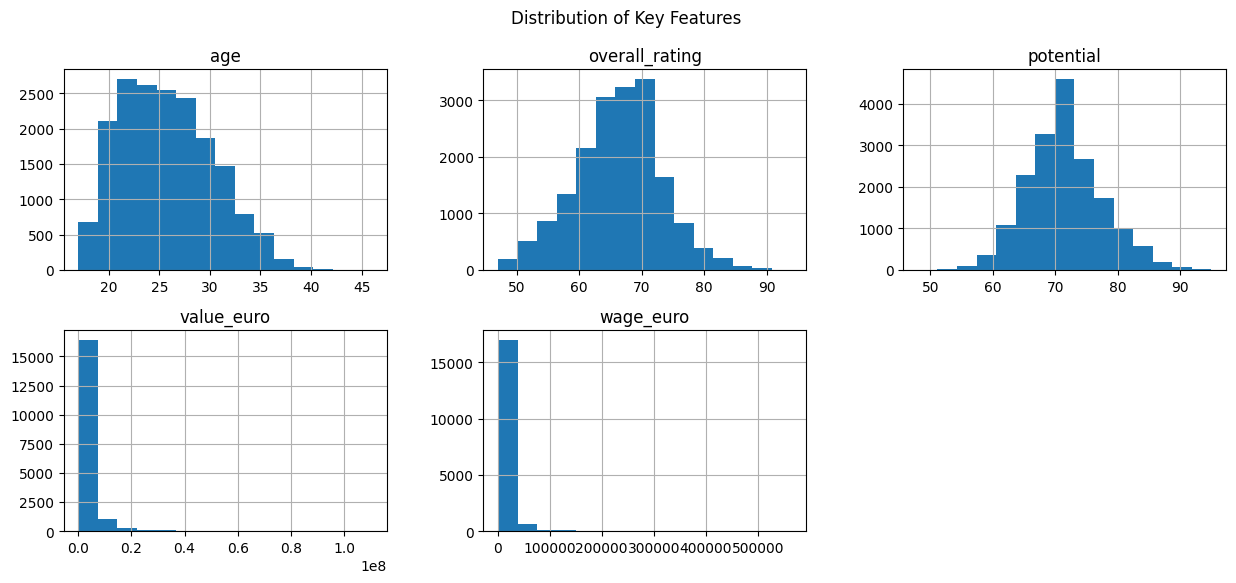

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for key numeric features
key_features = ['age', 'overall_rating', 'potential', 'value_euro', 'wage_euro']
fifa_data[key_features].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.suptitle("Distribution of Key Features")
plt.show()

In [9]:
import plotly.express as px

fig_rating_value = px.scatter(fifa_data, x='overall_rating', y='value_euro', title='Overall Rating vs. Market Value', labels={'value_euro': 'Market Value (Euro)', 'overall_rating': 'Overall Rating'})
fig_rating_value.show()

In [10]:
fig_potential_wage = px.scatter(fifa_data, x='potential', y='wage_euro', title='Potential vs. Wage', labels={'wage_euro': 'Wage (Euro)', 'potential': 'Potential'})
fig_potential_wage.show()

In [11]:
# Assuming 'positions' column contains positions separated by commas,
# we'll extract the primary position (the first one listed)
fifa_data['primary_position'] = fifa_data['positions'].str.split(',').str[0]

# Creating a boxplot of Wage Distribution by Primary Player Positions
fig = px.box(fifa_data, x='primary_position', y='wage_euro', title='Wage Distribution by Primary Player Positions')
fig.update_traces(quartilemethod="exclusive")  # or "inclusive", as per your preference
fig.update_layout(xaxis_title='Primary Position', yaxis_title='Wage (Euro)', xaxis={'categoryorder':'total descending'})
fig.show()

In [12]:
# Creating age groups
fifa_data['age_group'] = pd.cut(fifa_data['age'], bins=[0, 20, 25, 30, 35, 40, 100], labels=['<20', '21-25', '26-30', '31-35', '36-40', '>40'])

# Creating a boxplot
fig_age_group = px.box(fifa_data, x='age_group', y='value_euro', title='Market Value Distribution by Age Groups')
fig_age_group.update_layout(xaxis_title='Age Group', yaxis_title='Market Value (Euro)')
fig_age_group.show()

# **5. Model Development**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Defining the features and target variable
features = ['age', 'overall_rating', 'potential', 'international_reputation(1-5)', 'weak_foot(1-5)',
            'skill_moves(1-5)', 'age_to_potential_ratio', 'performance_index', 'weighted_skill_score']
targets = ['value_euro', 'wage_euro']

# Splitting the dataset
X = fifa_data[features]
y = fifa_data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}

# Function to train and evaluate models
def train_evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for target in y_train.columns:
        results[target] = {}
        for name, model in models.items():
            # Training the model on one target at a time
            model.fit(X_train, y_train[target])

            # Predicting on the test set
            y_pred = model.predict(X_test)

            # Evaluating the model
            rmse = mean_squared_error(y_test[target], y_pred, squared=False)  # Calculate RMSE
            r2 = r2_score(y_test[target], y_pred)  # Calculate R²

            # Storing results
            results[target][name] = {'RMSE': rmse, 'R²': r2}
    
    return results

# Now, use this function to train and evaluate each model
model_results = train_evaluate_models(models, X_train, X_test, y_train, y_test)

# Viewing the results
for target in model_results:
    print(f"Results for {target}:")
    for model_name, metrics in model_results[target].items():
        print(f"  {model_name}: RMSE - {metrics['RMSE']}, R² - {metrics['R²']}")
    print()

Results for value_euro:
  Linear Regression: RMSE - 3663232.331749525, R² - 0.6401428334553734
  Random Forest: RMSE - 997430.0752674529, R² - 0.9733212088453771
  Gradient Boosting: RMSE - 875618.3119182044, R² - 0.9794396312380907
  Support Vector Regression: RMSE - 6371458.70226824, R² - -0.08862668008338948

Results for wage_euro:
  Linear Regression: RMSE - 16068.49430104296, R² - 0.5526840146459081
  Random Forest: RMSE - 11292.600812952149, R² - 0.7790713671893703
  Gradient Boosting: RMSE - 11403.35307997188, R² - 0.7747165982413676
  Support Vector Regression: RMSE - 24857.91691506205, R² - -0.07051687215840596



# 6. Model Evaluation and Interpretation

In [14]:
# Feature importance from the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train['value_euro'])  # Example for 'value_euro' target

# Extracting feature importances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import plotly.express as px
fig_importance = px.bar(importance_df, x='Importance', y='Feature', title='Feature Importances for Market Value Prediction')
fig_importance.show()

# Report on FIFA Players' Market Value and Wage Prediction

## Introduction
This report presents an analysis of a dataset containing attributes of football players. The primary goal is to develop predictive models for players' market values and wages. The dataset includes physical attributes, skill ratings, and financial details of 17,954 football players.

## Data Overview
- **Entries and Features**: The dataset comprises 17,954 entries and 51 features.
- **Key Features**: Includes player names, ages, positions, nationalities, skill ratings, and financial information.
- **Target Variables**: The focus is on `value_euro` and `wage_euro`, representing each player's market value and wage.

## Data Cleaning and Preprocessing
- **Handling Missing Values**: Missing values in `value_euro` and `wage_euro` were imputed using median values.
- **Feature Engineering**: Created features such as `age_to_potential_ratio` and `performance_index`.

## Exploratory Data Analysis (EDA)
- **Statistical Summary**: Analyzed key features to understand distributions and basic statistics.
- **Feature Distribution**: Examined the distribution of age, overall rating, potential, etc.
- **Correlation Analysis**: Investigated correlations between features to understand their relationships.

## Model Development
- **Models Used**: Linear Regression, Random Forest, Gradient Boosting, and Support Vector Regression.
- **Data Split**: The data was split into an 80-20 training and testing set.

## Model Evaluation
- **Evaluation Metrics**: Used RMSE and R² to evaluate model performance.
- **Performance Comparison**: Compared the performance of each model.

## Model Interpretation
- **Feature Importance**: Analyzed which attributes significantly impact players' market values and wages.

## Conclusions
- **Key Findings**: Summarized significant outcomes from the analysis.
- **Limitations**: Discussed limitations in the analysis.
- **Recommendations**: Provided actionable recommendations based on findings.
- **Future Work**: Suggested areas for further analysis and model enhancement.